In [150]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt



# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=1095)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)

   
# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean() 
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
        lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")



# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN'),
            (    'Sentiment', 'AMZN')],
           )
             Adj Close       Close        High         Low        Open  \
                  AMZN        AMZN        AMZN        AMZN        AMZN   
Date                                                                     
2025-04-21  167.320007  167.320007  169.600006  165.289993  169.600006   
2025-04-22  173.179993  173.179993  176.779999  169.350006  169.850006   
2025-04-23  180.600006  180.600006  187.380005  180.190002  1

In [166]:
amzn_data.describe()

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,751.000000,751.000000,751.000000,751.000000,751.000000,7.510000e+02,7.510000e+02,750.000000,744.000000,745.000000,722.000000,387.000000,750.000000
mean,149.732752,149.732752,151.613964,147.679756,149.686673,5.565888e+07,3.411372e+01,0.000357,0.020836,149.683843,149.735022,145.292737,0.000639
std,40.862046,40.862046,41.059457,40.575733,40.875985,2.700315e+07,2.630760e-13,0.023779,0.010194,40.802081,40.538411,23.330423,0.023740
min,81.820000,81.820000,83.480003,81.430000,82.800003,1.500750e+07,3.411372e+01,-0.151398,0.004918,83.874286,88.232667,114.261919,-0.140494
25%,115.005001,115.005001,116.915001,113.139999,114.750000,3.870915e+07,3.411372e+01,-0.012186,0.013903,114.928571,114.104251,121.870110,-0.012112
50%,142.220001,142.220001,143.380005,139.910004,141.320007,4.920300e+07,3.411372e+01,0.000418,0.018606,141.051429,136.715667,143.935808,0.000418
75%,183.705002,183.705002,185.860001,181.709999,183.790001,6.503935e+07,3.411372e+01,0.014042,0.024463,183.532859,183.251167,165.301219,0.014141
max,242.059998,242.059998,242.520004,238.029999,239.020004,2.726620e+08,3.411372e+01,0.114915,0.067685,237.695714,230.223333,186.201206,0.121778


In [167]:
amzn_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2022-04-28 to 2025-04-25
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      751 non-null    float64
 1   (Close, AMZN)          751 non-null    float64
 2   (High, AMZN)           751 non-null    float64
 3   (Low, AMZN)            751 non-null    float64
 4   (Open, AMZN)           751 non-null    float64
 5   (Volume, AMZN)         751 non-null    int64  
 6   (PE_Ratio, AMZN)       751 non-null    float64
 7   (Log_Return, AMZN)     750 non-null    float64
 8   (Volatility_7d, AMZN)  744 non-null    float64
 9   (MA_7, AMZN)           745 non-null    float64
 10  (MA_30, AMZN)          722 non-null    float64
 11  (MA_365, AMZN)         387 non-null    float64
 12  (Pct_Change, AMZN)     750 non-null    float64
 13  (Sentiment, AMZN)      751 non-null    object 
dtypes: float64(12), int64(1), object(1)
mem

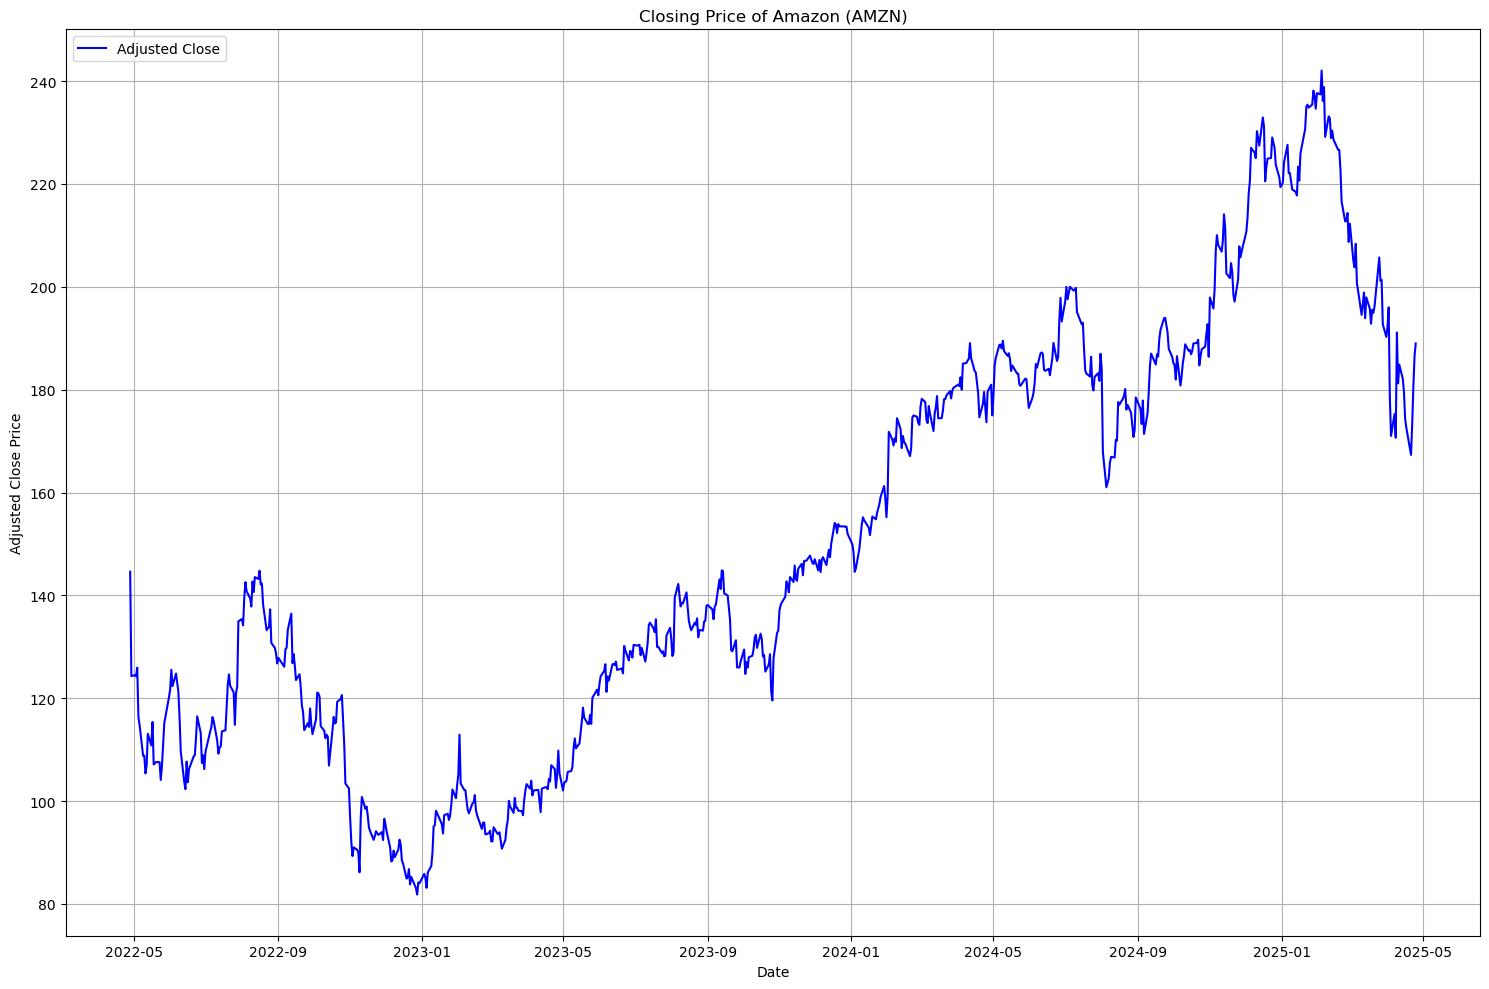

In [168]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()


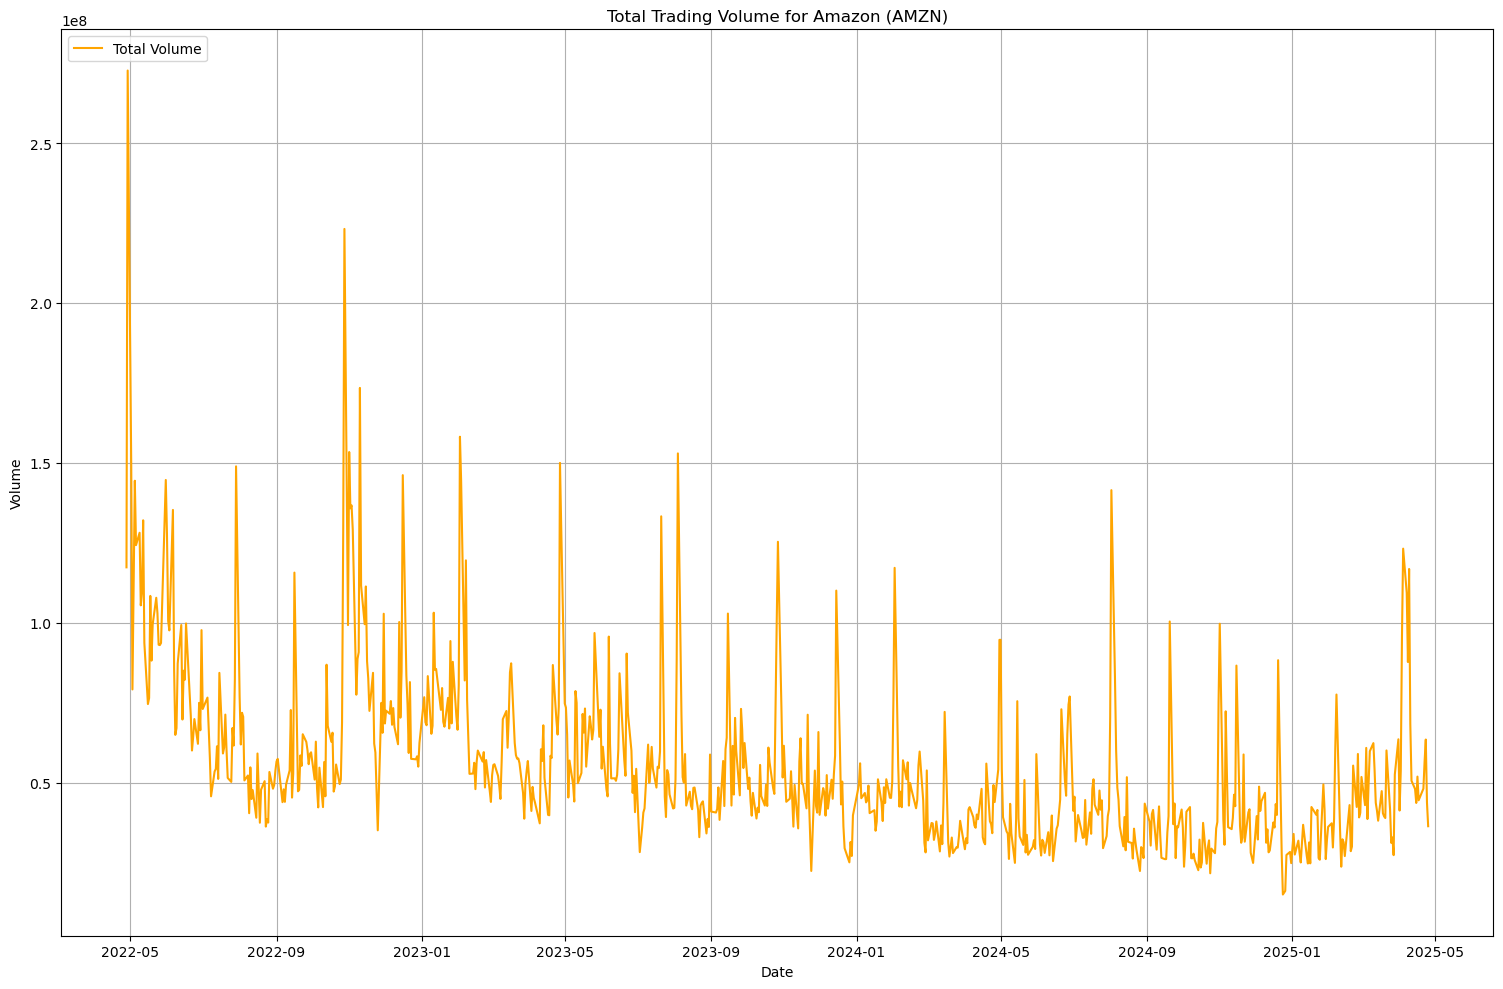

In [169]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

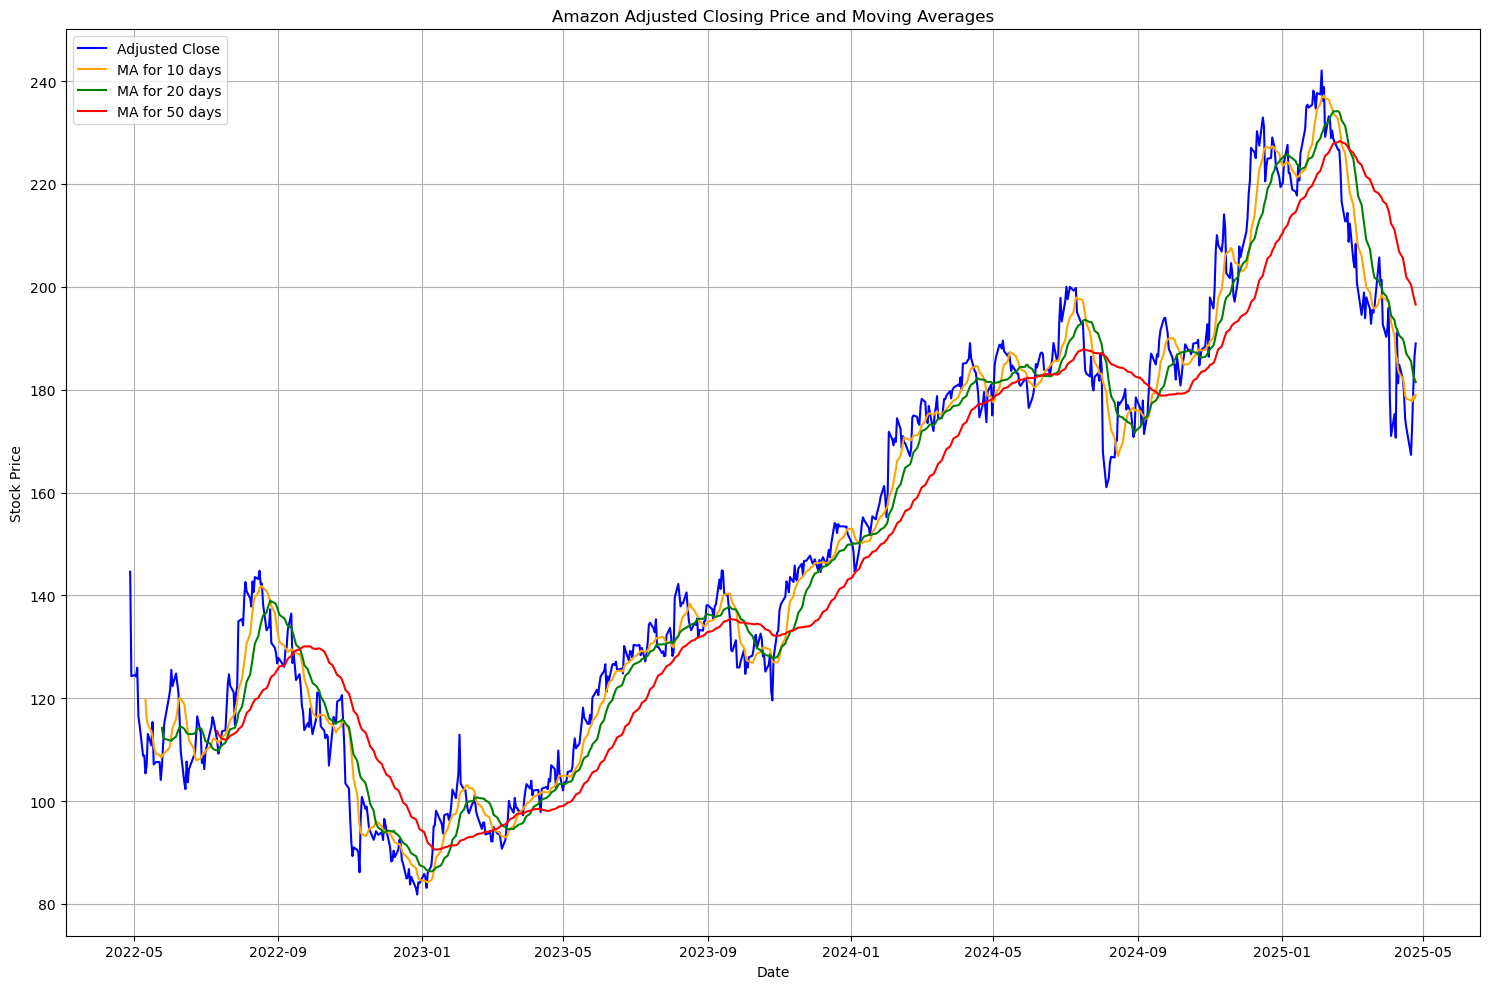

In [170]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


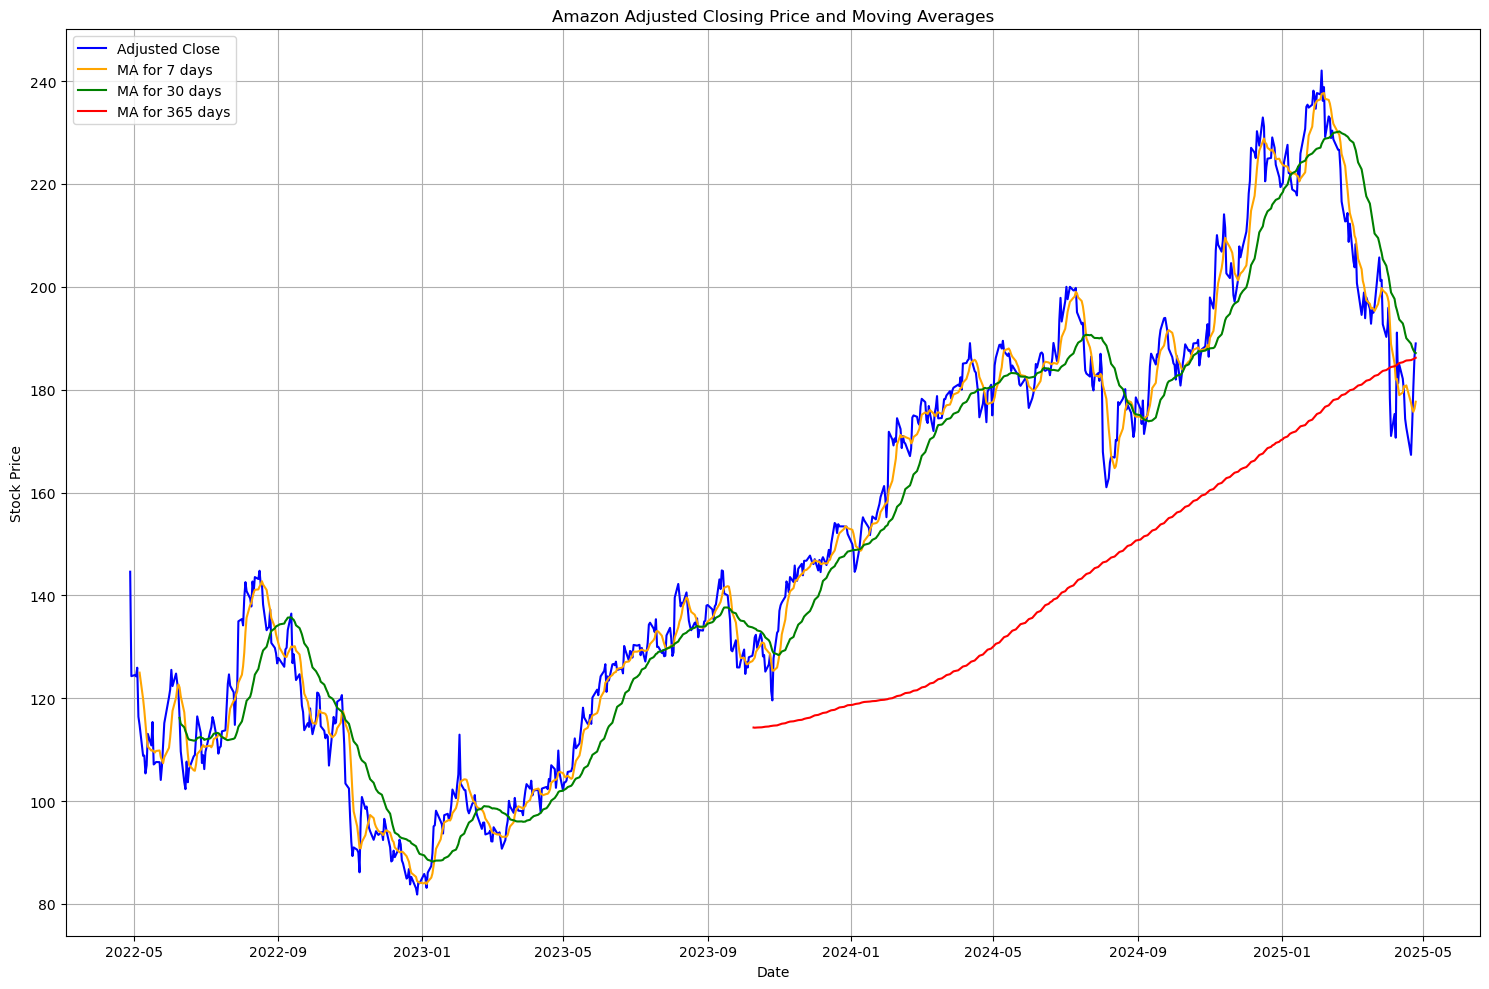

In [171]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


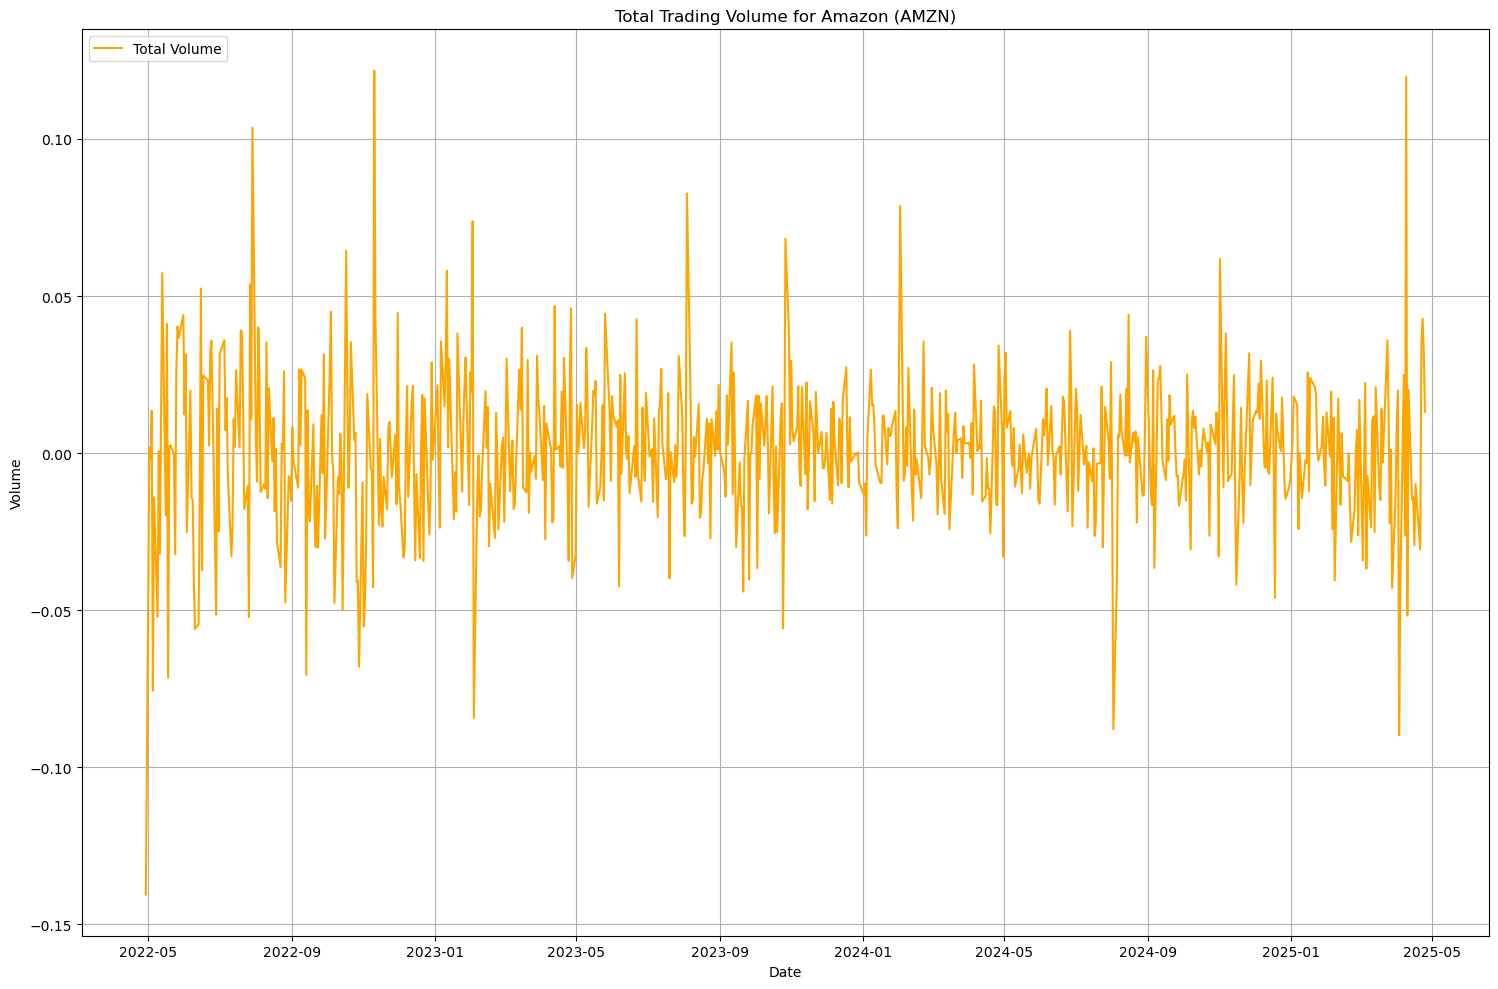

In [172]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

In [180]:
# Define Amazon's ticker symbol and the date range
ticker = 'AMZN'


# Grab adjusted closing prices for Amazon into a DataFrame
closing_df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)['Adj Close']

# Make a new returns DataFrame for Amazon
amazon_rets = closing_df.pct_change()

# Display the first few rows of the returns DataFrame
print(amazon_rets.head())

# Optional: Visualizing Amazon's daily returns
plt.figure(figsize=(10, 6))
sns.histplot(amazon_rets.dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()

AttributeError: 'NoneType' object has no attribute 'group'

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Drop NaN values resulting from calculations
amzn_data = amzn_data.dropna()

# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']

# Create feature dataset and target variable
X = amzn_data[features]

y = amzn_data['Sentiment'].replace({'Bullish': 1, 'Neutral': 0, 'Bearish': -1})

# Align X and y
X = X[:-1]  # Drop the last row of X to match the length of y
y = y[1:]   # Drop the first row of y to match the length of X

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Output the shapes of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (308, 13)
Testing Features Shape: (78, 13)
Training Target Shape: (308, 1)
Testing Target Shape: (78, 1)


/var/folders/r7/b96ymt_s1kz4r7c6skr6lbn00000gn/T/ipykernel_14694/215825187.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = amzn_data['Sentiment'].replace({'Bullish': 1, 'Neutral': 0, 'Bearish': -1})


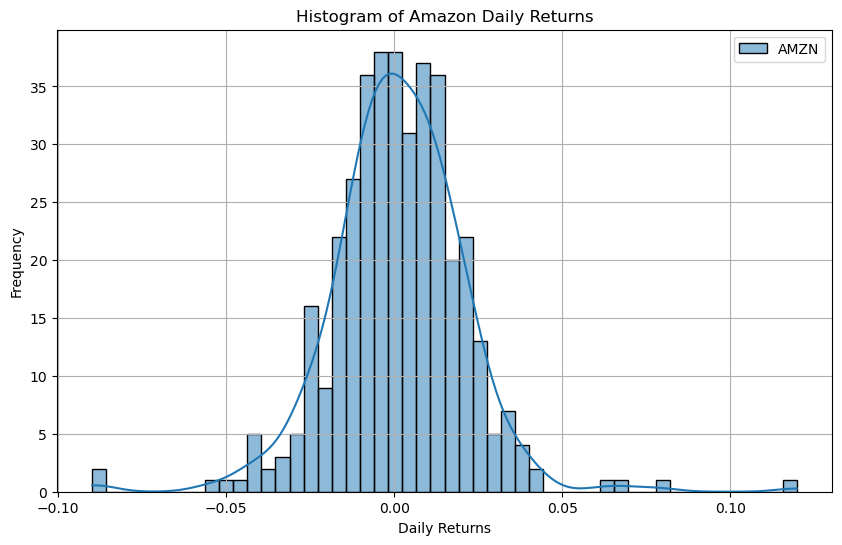

In [186]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()
